In [1]:
import scipy.sparse as sp
import numpy as np
import numpy.linalg as la
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
%ls
%cd 'gdrive/MyDrive/mipt-opt/hw7'
%ls

gdrive/  sample_data/
/content/gdrive/MyDrive/mipt-opt/hw7
mipt-opt-hw7.html   Momentum.png  Seminars7fivt.ipynb
mipt-opt-hw7.ipynb  PCG.png


In [4]:
%%shell
jupyter nbconvert --to html mipt-opt-hw7.ipynb

[NbConvertApp] Converting notebook mipt-opt-hw7.ipynb to html
[NbConvertApp] Writing 543931 bytes to mipt-opt-hw7.html


##  Первое задание. Предобусловленный метод сопряженных градиентов.

Задача, решить линейную систему:
$$
Ax = b
$$

Где $A$ -  матрица оператора Лапласа, $b$ константный вектор.



$$
\begin{equation}
A =  \frac{1}{h^2}
\begin{pmatrix}
2 & -1 & \cdots & 0 &0 \\
-1 & 2 & \cdots & 0 & 0\\
\vdots  & \vdots  & \ddots & \vdots & \vdots \\
0 & 0& \cdots & 2 &-1 \\
0 & 0& \cdots &-1 & 2
\end{pmatrix}
\end{equation}
$$

$h$ - Шаг сетки. Пусть сетка равномерная, тогда $h=\frac{1}{n+1}$, где $n+1$ - количество узлов в сетке. 


Задать такую матрицу и вектор можно следкющим образом 

In [5]:
#n можно взять любым больше 100. Перевести разрженную матрицу в плотную можно мотодом toarray()
np.random.seed(123)

n = 1000
A =  sp.diags([-1, 2, -1], [-1,0,1], shape = (n, n)) 
A =  A *(n+1)**2

#константный вектор правой части
b =  np.ones(n) * 6.

# рандомная начальная точка
x_0 = np.random.rand(n)

x_solution = sla.spsolve(A, b)

Число обусловленности такой матрицы будет большим

In [6]:
w, _= np.linalg.eig(A.toarray())
la.cond(A.toarray()), max(w)/min(w)

(406095.0426591316, 406095.04265891394)

In [7]:
np.isclose(max(w)/min(w), np.linalg.cond(A.toarray()))

True

Проверить, как отработает метод сопряженных градиентов на такой задаче. (Метод можно взять из семинара)

In [67]:
def ConjugateGradient(x_0, A, b, tol=1e-8, max_iter=1e4, step_callback=None, sparse=True):
    x_k = x_0
    r_k = b - A@x_k
    p_k = np.zeros(shape=r_k.shape)
    
    k = 0
    prev_beta_denominator = r_k@r_k
    while la.norm(r_k) > tol:
        if k == max_iter:
            raise Exception(f"Number of iterations exceeded {max_iter}")
        beta_k = r_k@r_k / prev_beta_denominator
        prev_beta_denominator = r_k@r_k

        p_k = r_k + beta_k*p_k
        w = A@p_k
        alpha = (r_k@r_k) / (p_k@w)
        x_k = x_k + alpha*p_k
        r_k = r_k - alpha*w
        k += 1
        if step_callback is not None:
            step_callback(x_k)
    return x_k

In [68]:
xs = list()
iters = 0

def callback(x):
    global iters
    xs.append(x)
    iters += 1

x_solutionCG = ConjugateGradient(x_0, A, b, step_callback=callback)
np.allclose(x_solution, x_solutionCG), iters

(True, 27)

Написать метод сопряженных градиентов, учитывая действие предобуславлевателя. 
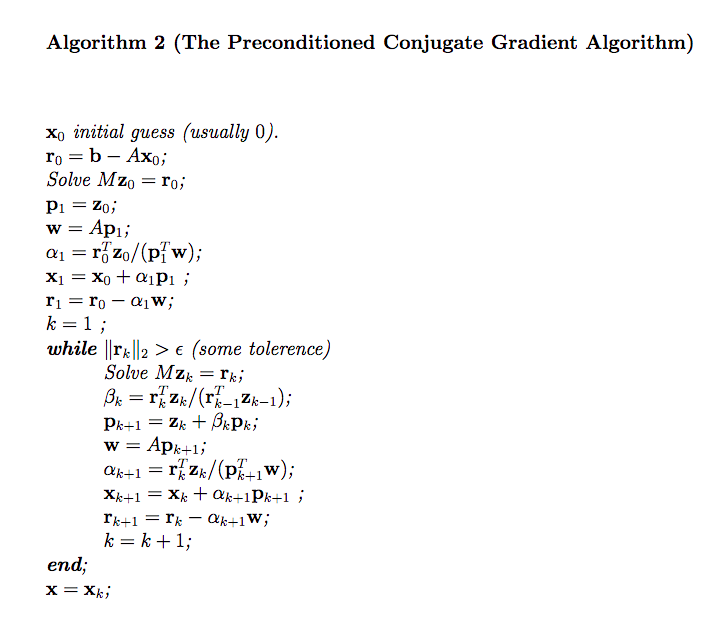

([Полный текст тут](http://www.cse.psu.edu/~b58/cse456/lecture20.pdf))

Написать метод сопряженных градиентов, учитывая действие предобуславлевателя. 

In [50]:
def PreconditionedCG(x_0, A, b, M=None, tol=1e-8, max_iter=1e4, step_callback=None, sparse=True):
    if M is None:
        M = (A + A.T) / 2
    x_k = x_0
    r_k = b - A@x_k
    p_k = np.zeros(shape=r_k.shape)
    
    k = 0
    prev_beta_denominator = 1
    while la.norm(r_k) > tol:
        if k == max_iter:
            raise Exception(f"Number of iterations exceeded {max_iter}")
        z_k = sla.spsolve(M, r_k) if sparse else la.solve(M, r_k)

        beta_k = r_k@z_k / prev_beta_denominator
        prev_beta_denominator = r_k@z_k

        p_k = z_k + beta_k*p_k
        w = A@p_k
        alpha = (r_k@z_k) / (p_k@w)
        x_k = x_k + alpha*p_k
        r_k = r_k - alpha*w
        k += 1
        if step_callback is not None:
            step_callback(x_k)
    return x_k

Проверить работу метода на предобуславлевателе Гаусса-Зейделя. Обратите внимание, что есть симметричный и не симметричные варианты. Какой надо взять?([Статья с предобуславлевателями для метода сопряжённых градиентов](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.592.1575&rep=rep1&type=pdf))

"*Вспоминаем стыдную байку с семинара про несимметричную матрицу*" 

Берем симметричный вариант, потому что иначе алгоритм работать (сходится) не будет =(

In [70]:
def CalculateM(A, sparse=True):
    if sparse:
        D = sp.diags(A.diagonal())
        U = sp.triu(A)
        L = sp.tril(A)
        return L @ sla.inv(D) @ U
    else:
        D = np.diag(A.diagonal())
        U = np.triu(A)
        L = np.tril(A)
        return L @ la.inv(D) @ U

In [69]:
def check_Ms(Ms):
    iters = [0] * len(Ms)
    xs = [[]] * len(Ms)

    def callback_constructor(ind):
        def callback(x):
            xs[ind].append(x)
            iters[ind] += 1
        return callback

    for ind, m in enumerate(Ms):
        x_solutionPCG = PreconditionedCG(x_0, A, b, M=m, step_callback=callback_constructor(ind))
        assert np.allclose(x_solution, x_solutionPCG)

    return iters

check_Ms([None, CalculateM(A)])

[1, 10]

In [72]:
res = None
try:
    res = check_Ms([L])
    print(res)
except Exception:
    print("Oops")

try:
    res = check_Ms([U])
    print(res)
except Exception:
    print("Oops")

Oops
Oops


Вывод: не сходится с несимметричной матрицей

Сравните результат работы предобусловленной и непредобусловленной версии

Будем генерировать разреженные положительно определенные матрицы и искать минимум на них

In [90]:
def compare_methods(checks, n, A_gen, sparse=True):
    iters = np.zeros(shape=(2, checks), dtype=np.int64)
    
    def callback_constructor(ind, check):
        def callback(x):
            iters[ind][check] += 1
        return callback

    As = np.array([A_gen() for check in range(checks)])
    bs = np.random.rand(checks, n) * 6
    x_0s = np.random.rand(checks, n)

    is_spd = np.all(np.array([la.eigvals(A.toarray() if sparse else A) for A in As]))

    for check, (A, x_0, b) in enumerate(zip(As, x_0s, bs)):
        x_solution = sla.spsolve(A, b) if sparse else la.solve(A, b)
        M = CalculateM(A, sparse=sparse)

        x_solutionCG = ConjugateGradient(x_0, A, b, step_callback=callback_constructor(0, check), sparse=sparse)
        assert np.allclose(x_solution, x_solutionCG)

        x_solutionCG = PreconditionedCG(x_0, A, b, M=M, step_callback=callback_constructor(1, check), sparse=sparse)
        assert np.allclose(x_solution, x_solutionCG)
    return iters, is_spd

Построим распределение количества итераций у двух алгоритмов в случае разреженных матриц

Все матрицы будут положительно определенные (проверил это в коде) и по построению симметричные

Все четко


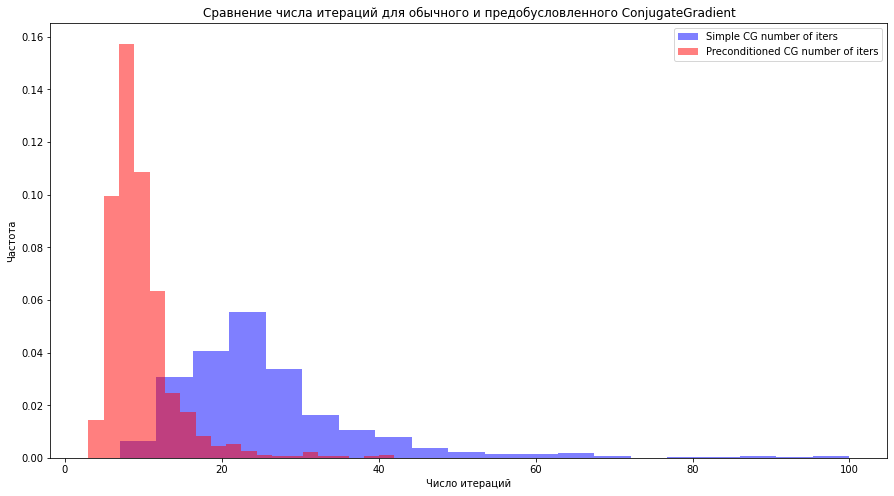

In [93]:
n = 100
checks = 1000

def generate_A():
    A_diag = -np.random.rand(3)
    A_diag = A_diag + A_diag[::-1]
    A_diag[1] = 4
    A = sp.diags(A_diag, [-1,0,1], shape = (n, n))
    A = A*(n+1)**2
    return A

iters, is_spd = compare_methods(checks, n, generate_A)

print("Все четко" if is_spd else "Где-то косяк")

plt.figure(figsize=(15, 8))

plt.hist(iters[0], bins=20, density=True, color='b', alpha=0.5, label='Simple CG number of iters')
plt.hist(iters[1], bins=20, density=True, color='r', alpha=0.5, label='Preconditioned CG number of iters')

plt.title("Сравнение числа итераций для обычного и предобусловленного ConjugateGradient")

plt.xlabel("Число итераций")
plt.ylabel("Частота")

plt.legend()
plt.show()

In [96]:
print(f"В {np.mean(iters[1] < iters[0]):.0%} случаев предобусловленный метод был лучше")

В 100% случаев предобусловленный метод был лучше


Т.е. в рассмотренных случаях предобусловленный метод всегда работал быстрее непредобусловленного. Заметим, что при этом не учитывается число операций, требуемое на дополнительное решение уравнения $Mz_k = r_k$

Теперь построим распределение количества итераций у двух алгоритмов в случае неразреженных матриц

Все четко


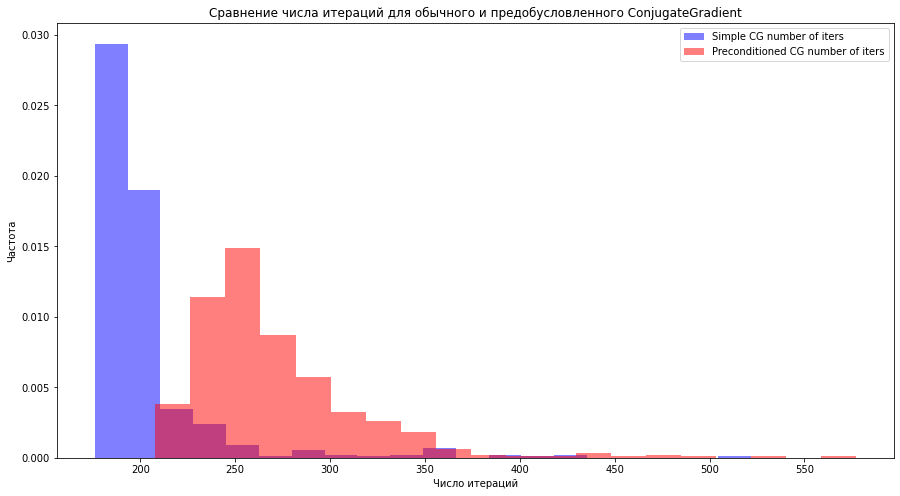

In [103]:
n = 100
checks = 500

def generate_A():
    A = np.random.rand(n, n)
    return A@A.T

iters, is_spd = compare_methods(checks, n, generate_A, sparse=False)

print("Все четко" if is_spd else "Где-то косяк")

plt.figure(figsize=(15, 8))

plt.hist(iters[0], bins=20, density=True, color='b', alpha=0.5, label='Simple CG number of iters')
plt.hist(iters[1], bins=20, density=True, color='r', alpha=0.5, label='Preconditioned CG number of iters')

plt.title("Сравнение числа итераций для обычного и предобусловленного ConjugateGradient")

plt.xlabel("Число итераций")
plt.ylabel("Частота")

plt.legend()
plt.show()

In [104]:
print(f"В {np.mean(iters[1] < iters[0]):.0%} случаев предобусловленный метод был лучше")

В 0% случаев предобусловленный метод был лучше


Вот здесь уже количество итераций, даже без учета операций на решение дополнительного уравнения, будет больше. Как следствие, в этом случае, предобусловленный метод будет работать значительно хуже

## Второе задание. Метод момента

Реализовать Метод момента.

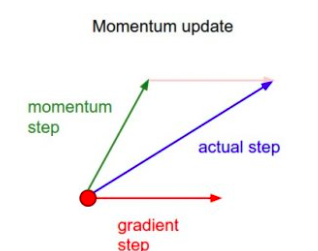

([Картинка отсюда](https://cs231n.github.io/neural-networks-3/))

In [108]:
import types

def backtracking (x, f, grad_f, rho, alpha0, beta1, beta2):
    alpha = alpha0
    if isinstance(grad_f ,types.FunctionType):
        phi1 = f(x) -  beta1 * alpha * grad_f(x).dot(grad_f(x))
        phi2 = f(x) -  beta2 * alpha * grad_f(x).dot(grad_f(x))    
        f_k = f(x - alpha * grad_f(x)) 
    else:
        phi1 = f(x) -  beta1 * alpha * grad_f @ grad_f
        phi2 = f(x) -  beta2 * alpha * grad_f @ grad_f  
        f_k = f(x - alpha * grad_f) 

    while not ((f_k <=phi1) and 
              (f_k >=phi2)):
        alpha *= rho
        
        if isinstance(grad_f ,types.FunctionType):
            phi1 = f(x) -  beta1 * alpha * grad_f(x).dot(grad_f(x))
            phi2 = f(x) -  beta2 * alpha * grad_f(x).dot(grad_f(x))    
            f_k = f(x - alpha * grad_f(x)) 
        else: 
            phi1 = f(x) -  beta1 * alpha * grad_f @ grad_f
            phi2 = f(x) -  beta2 * alpha * grad_f @ grad_f  
            f_k = f(x - alpha * grad_f) 
        if alpha < 1e-17:

            return alpha / rho

    return alpha

def get_x_y_from_callback(array):
    return array[:, 0], array[:, 1]

In [109]:
def NesterovAcceleratedGD(f, gradf, x0, momentum_coef=0.9, max_iter=1000, tol=1e-8, rho=0.5, beta1=0.2):
    x = x0.copy()
    iteration = 0
    conv_array = [x0]
    momentum = np.zeros(x.shape)
    beta2 = 1 - beta1

    while True:
        x_ahead = x + momentum_coef * momentum
        gradient = gradf(x_ahead)
        alpha = backtracking (x_ahead, f, gradf, rho=rho, alpha0=1., beta1=beta1, beta2=beta2)
        momentum = momentum_coef * momentum - alpha * gradient
        x = x + momentum
        
        iteration += 1
        if np.linalg.norm(gradf(x)) < tol:
            break
        if iteration >= max_iter:
            break
        conv_array.append(x)
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x)),  "conv_array": np.array(conv_array)}
    return res

In [129]:
def MomentumGD(f, gradf, x0, momentum_coef=0.9, max_iter=1000, tol=1e-8, rho=0.5, beta1=0.2):
    x = x0.copy()
    iteration = 0
    conv_array = [x0]
    momentum = np.zeros(x.shape)
    beta2 = 1 - beta1
   
    while True:
        gradient = gradf(x)
        alpha = backtracking (x, f, gradf, rho=rho, alpha0=1., beta1=beta1, beta2=beta2)
        momentum = momentum_coef * momentum - alpha * gradient
        x = x + momentum

        iteration += 1
        if np.linalg.norm(gradf(x)) < tol:
            break
        if iteration >= max_iter:
            break
        conv_array.append(x)
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x)),  "conv_array": np.array(conv_array)}
    return res

In [166]:
def GradientDescent(f, gradf, x0, max_iter=1000, tol=1e-8, rho=0.5, beta1=0.2):
    x = x0.copy()
    iteration = 0
    conv_array = [x0]
    beta2 = 1 - beta1
   
    while True:
        gradient = gradf(x)
        alpha = backtracking (x, f, gradf, rho=rho, alpha0=1., beta1=beta1, beta2=beta2)
        x = x - alpha * gradient

        iteration += 1
        if np.linalg.norm(gradf(x)) < tol:
            break
        if iteration >= max_iter:
            break
        conv_array.append(x)
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x)),  "conv_array": np.array(conv_array)}
    return res

Сравнить его с методом Нестерова и методом градиентного спуска, которые были преддставлены на семинаре. Сравнивать можно на $2D$  задаче с семинара

In [164]:
sns.set()
np.random.seed(23)
n=100
# строим и нормализуем матрицу
A = np.array([[4,3], [3,4]])
U = np.random.rand(2, 2)
Q, _ = np.linalg.qr(U)
A = Q.dot(A).dot(Q.T)
A = (A + A.T) * 0.5

n_points = 100

u = np.linspace(-6, 6, n_points)
x, y = np.meshgrid(u, u)
b = np.random.rand(2)
X = np.vstack([x.flatten(), y.flatten()])

# вспомогательные функции для кастомного Gradient DEscent
f = lambda x: 0.5 * x.T.dot(A.dot(x)) - b.dot(x)
grad_f = lambda x: A.dot(x) - b

# строим изолинии
f_x = np.diag(f(X)).reshape(n_points, n_points)

# начальное приближение
x0 = np.array([5. , 5.])

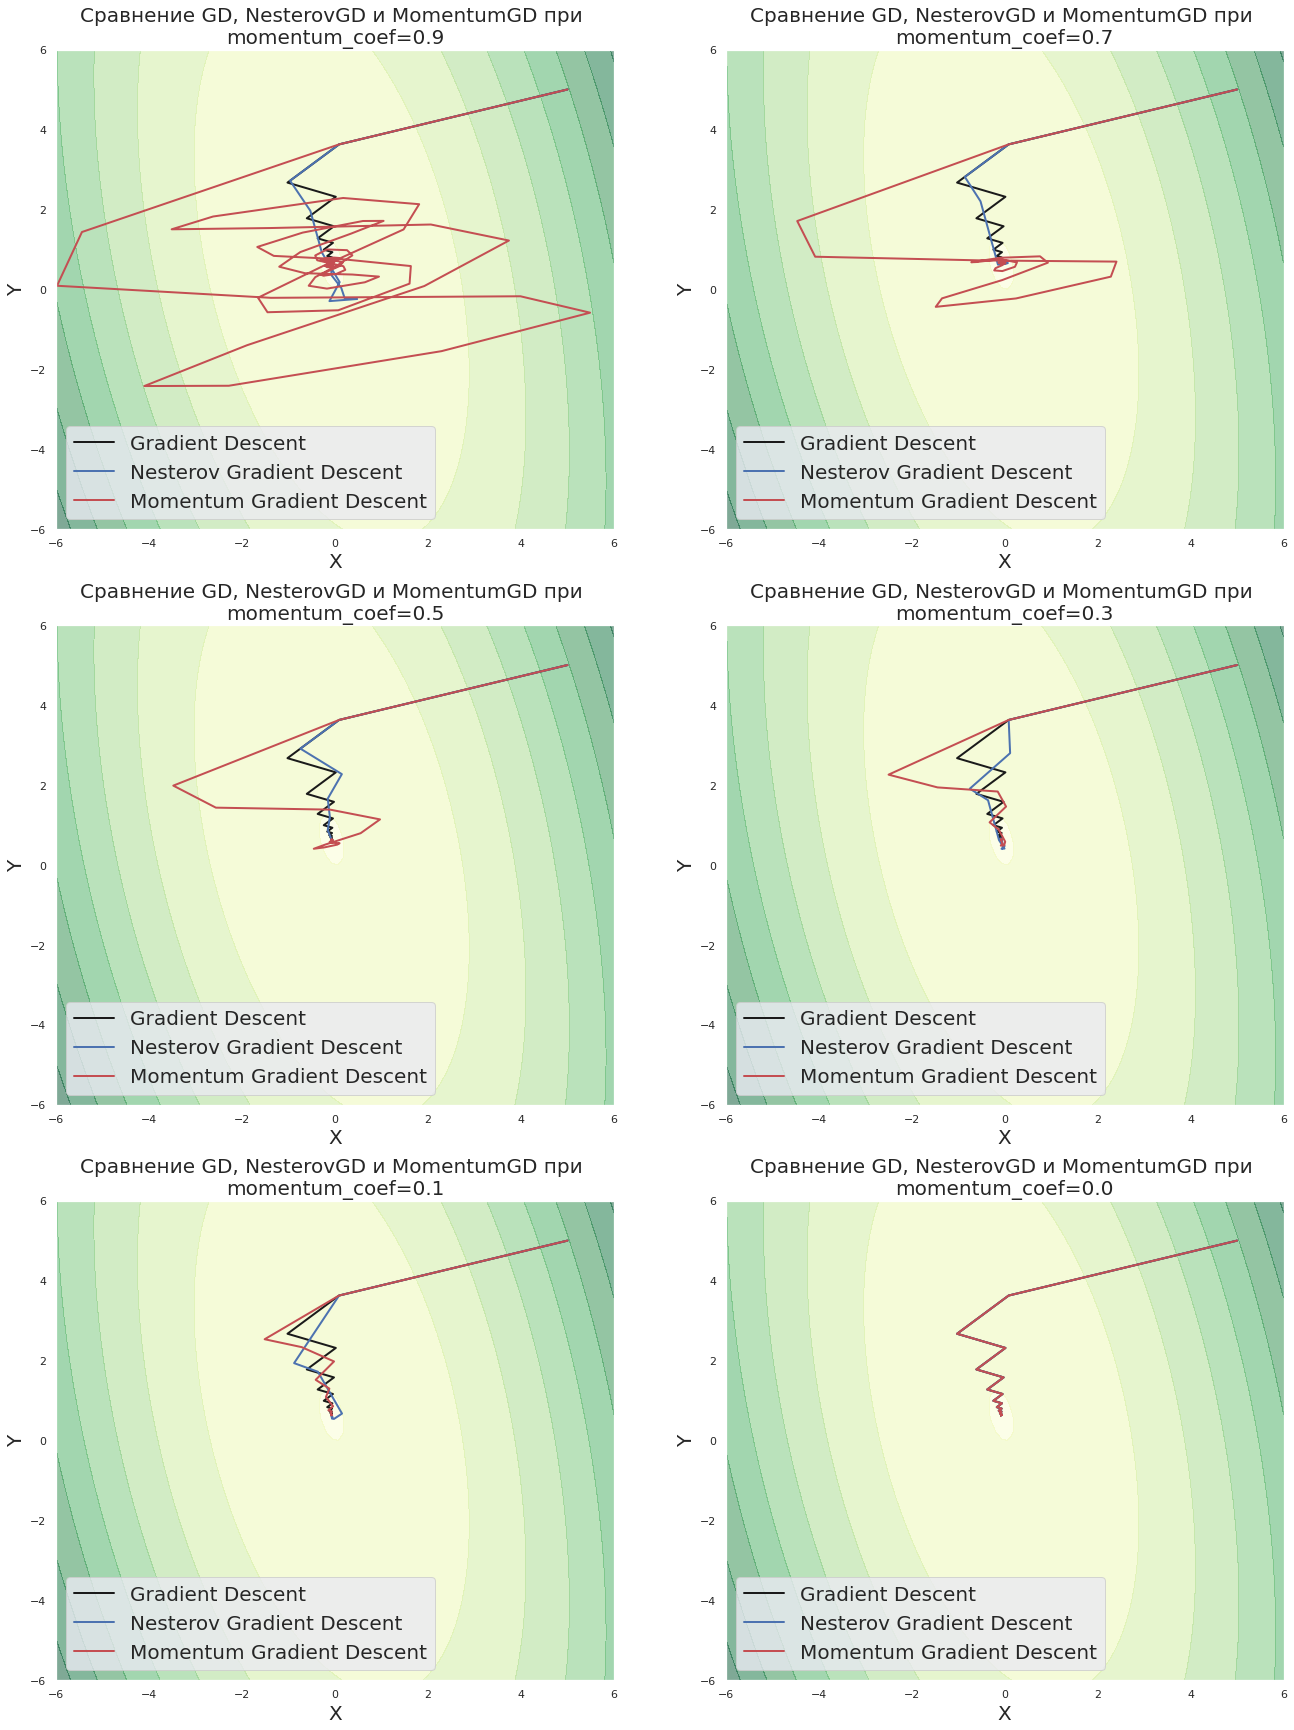

In [169]:
fig, axs = plt.subplots(3, 2, figsize = (22, 30))

for ax, momentum_coef in zip(axs.flatten(), [0.9, 0.7, 0.5, 0.3, 0.1, 0.]):
    res_gd = GradientDescent(f, grad_f, x0)
    x_gd, y_gd = get_x_y_from_callback(res_gd["conv_array"])

    res_nest = NesterovAcceleratedGD(f, grad_f, x0, momentum_coef=momentum_coef)
    x_na, y_na = get_x_y_from_callback(res_nest["conv_array"])

    res_mom = MomentumGD(f, grad_f, x0, momentum_coef=momentum_coef)
    x_m, y_m = get_x_y_from_callback(res_mom["conv_array"])


    ax.set_facecolor('white')

    ax.contourf(x, y, f_x, alpha=0.5, cmap='YlGn')

    ax.plot(x_gd, y_gd, color='k', linewidth=2, alpha=1, label='Gradient Descent')
    ax.plot(x_na, y_na, color='b', linewidth=2, alpha=1, label='Nesterov Gradient Descent')
    ax.plot(x_m, y_m, color='r', linewidth=2, alpha=1, label='Momentum Gradient Descent')

    ax.set_xlabel('X', fontsize=20)
    ax.set_ylabel('Y', fontsize=20)

    ax.set_title(f"Сравнение GD, NesterovGD и MomentumGD при \nmomentum_coef={momentum_coef}", fontsize=20)
    ax.legend(loc="best", fontsize=20)

plt.show()

Как видно, метод моментов "заносит" на поворотах: он часто пролетаем мимо точек и не учитывает изменения градиента при шаге с учетом момента, поэтому он проигрывает даже обычному градиентному спуску. Нестеров же, в свою очередь, это учитывает, поэтому его и не заносит так сильно, он быстрее сходится к правильному ответу

Кроме того, как можно заметить на последнем графике, получаем, что при нулевом коэффициенте момента получается обычный градиентный спуск